## Loading data and preliminary analysis

In [ ]:
!pip install underthesea
!pip install datasets
!pip install pyvi

In [2]:
import re
import random
import pandas as pd
import numpy as np
from pyvi import ViTokenizer
from collections import Counter
import string, unicodedata
pd.set_option('mode.chained_assignment', None)

In [3]:
!gdown https://drive.google.com/uc?id=1959T-bYk-TljBJVMiy8tx8qkfVY2HtF5
!gdown https://drive.google.com/uc?id=1l8U4Sol9FFMpQdJBbwFqllbr2lNmxt52
!gdown https://drive.google.com/uc?id=11RwYCZKhb1u4ZBqd2MChWFAeqUIT9QJt

Downloading...
From: https://drive.google.com/uc?id=1959T-bYk-TljBJVMiy8tx8qkfVY2HtF5
To: /content/vietnamese-stopwords.txt
100% 22.4k/22.4k [00:00<00:00, 52.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l8U4Sol9FFMpQdJBbwFqllbr2lNmxt52
To: /content/wiki.vi.vec
100% 764M/764M [00:04<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?id=11RwYCZKhb1u4ZBqd2MChWFAeqUIT9QJt
To: /content/dataset.xlsx
100% 4.90M/4.90M [00:00<00:00, 182MB/s]


In [4]:
data= pd.read_excel('/content/dataset.xlsx', 'true_value')

In [5]:
data.columns = ['Questions',	'Full_questions',	'Answers']

In [6]:
data = data[data['Answers'].str.len() < 550]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1123 entries, 0 to 1122
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Questions       1123 non-null   object
 1   Full_questions  1123 non-null   object
 2   Answers         1123 non-null   object
dtypes: object(3)
memory usage: 35.1+ KB


In [8]:
data.head()

,Questions,Full_questions,Answers
0,"Kết quả PDW cao hơn bình thường, có đáng lo?","Nhờ bác sĩ tư vấn giúp em, chỉ số PDW của em h...","Kết quả PDW là độ phân bố tiểu cầu, tuy hơi ca..."
1,Kết quả xét nghiệm 0.3 liệu đã nhiễm sán chó?,"Chào BS ạ, Kết quả xét nghiệm sán chó của em 0...",Chu trình phát triển của sán chó Kết quả xét n...
2,"Lưỡi nổi nhiều chấm đỏ, có bất thường?","Bác sĩ ơi, lưỡi em có nhiều chấm đỏ như hình t...",Hình ảnh bạn gửi là cấu trúc gai vị giác bình ...
3,BS ơi có phải em bị sùi mào gà?,"Chào BS ạ, Bác sĩ xem họng em có phải bị sui m...",Ảnh bạn đọc cung cấp cho AloBacsi Xin chào bạn...
4,Nhờ Alobacsi đọc giúp kết quả khám mắt,"Chào bác sĩ. Tôi đi khám mắt, bác sĩ khám cho ...",Kết quả này là bạn vừa có cận thị kèm loạn thị...


In [10]:

EMOTICONS = {
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u":))":"Happy face smiley",
    u":)))":"Happy face smiley",
    u":))))":"Happy face smiley",
    u":'<":"Happy face smiley",
    u":)":"Happy face smiley",
    u":(":"Happy face smiley",
    u":((":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u"D:":"Sadness",
    u":O":"Surprise",
    u":o":"Surprise",
}


with open('/content/vietnamese-stopwords.txt', 'r' , encoding='utf-8') as f:
    stopwords = f.read().splitlines()
    stopwords = [i for i in stopwords if i.find(" ")==-1]
bang_nguyen_am= [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']
nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)


def standardize_unicode(text):
	text = unicodedata.normalize('NFC', text)
	return text


def standardize_word(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]

        else:

            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:

        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]

    return ''.join(chars)

def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

def standardize_punctuation(sentence):

    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = standardize_word(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

def remove_emoticons(text):
    "Function to remove emoticons"
    arr = [word for word in text.split() if word not in EMOTICONS.keys()]
    return " ".join(arr)

def get_lower(text):
        return text.lower().strip()

def standardize_sentence(text):
	text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text

def remove_tag (text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

def remove_url(text):
    pattern = re.compile(r'http\S+')
    return pattern.sub(r'',text)

def remove_number(text):
    pattern = re.compile(r'[\d]+')
    return pattern.sub(r'',text)

def remove_punc(text):
    exclude = string.punctuation
    for char in exclude:
        text = text.replace(char,'')
    return text

def remove_stopW(text):
    new_text=[]
    for word in text.split():
        if word in stopwords:
            new_text.append('')
        else:
            new_text.append(word)
    x = [i for i in new_text if i != '']
    new_text.clear()
    return " ".join(x)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def add_start_end(text):
  return "START " + text + " END"


def preprocess(text):
  # text = text.lower()                                                 # chuyển về chữ thường
  # text = re.sub(r'[!“”"’#$%&\()*+,./:;<=>?@[\]^_`{|}~]', "", text)    # loại bỏ kí tự đặt biệt
  text = ViTokenizer.tokenize(text)                                   # word segmentation
  return text

def clean_data(text):
    text = remove_emoticons(text)
    text = get_lower(text)
    text = remove_tag(text)
    text = remove_url(text)
    # text = remove_stopW(text)
    text = remove_emoji(text)
    text = remove_punc(text)
    text = remove_number(text)
    text = standardize_unicode(text)
    # text = standardize_punctuation(text)
    text = standardize_sentence(text)
    text = preprocess(text)
    # text = add_start_end(text)

    return text

In [11]:
pairs=[]

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]),data['Answers'][i]))

## Data preprocessing

In [13]:
input_docs = []
output_docs = []
input_tokens = set()
output_tokens = set()

def preprocess(text):
  text = text.lower()                                                 # chuyển về chữ thường
  # text = re.sub(r'[!“”"’#$%&\()*+,./:;<=>?@[\]^_`{|}~]', "", text)    # loại bỏ kí tự đặt biệt
  text = ViTokenizer.tokenize(text)                                   # word segmentation
  return text

def get_lower(text):
        return text.lower().strip()

def standardize_sentence(text):
	text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text

def change_word(text):
  # text = get_lower(text)
  text = standardize_sentence(text)
  text = preprocess(text)
  return text


for line in pairs:

  input_doc, output_doc = line[0], line[1]
  input_doc = clean_data(input_doc)
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)

  # Splitting words from punctuation
  output_doc = clean_data(output_doc)
  output_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", output_doc))

  # Redefine output_doc below and append it to output_docs
  output_doc = '<START> ' + output_doc + ' <END>'

  output_docs.append(output_doc)

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in output_doc.split():
    if token not in output_tokens:
      output_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
output_tokens = sorted(list(output_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(output_tokens)

In [16]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(output_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

## Encoder - Decoder model

In [18]:
# Calculate the maximum sequence length for encoder and decoder
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", output_doc)) for output_doc in output_docs])

# Initialize encoder_input_data, decoder_input_data, and decoder_target_data
encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# Iterate through input_docs and output_docs to populate encoder_input_data, decoder_input_data, and decoder_target_data
for line, (input_doc, output_doc) in enumerate(zip(input_docs, output_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.

    for timestep, token in enumerate(output_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

## Training

In [21]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model
dimensionality = 256 # Dimensionality
batch_size = 10   # The batch size and number of epochs
epochs = 200

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # Compiling

In [23]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1673)]         0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 4226)]         0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                1976320   ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

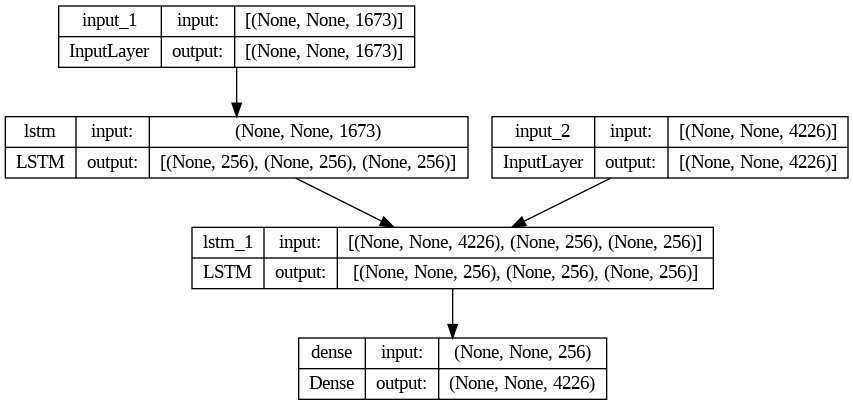

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [ ]:
training_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')
history1=training_model.fit([encoder_input_data, decoder_input_data],
                            decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
training_model.save('training_model.h5')

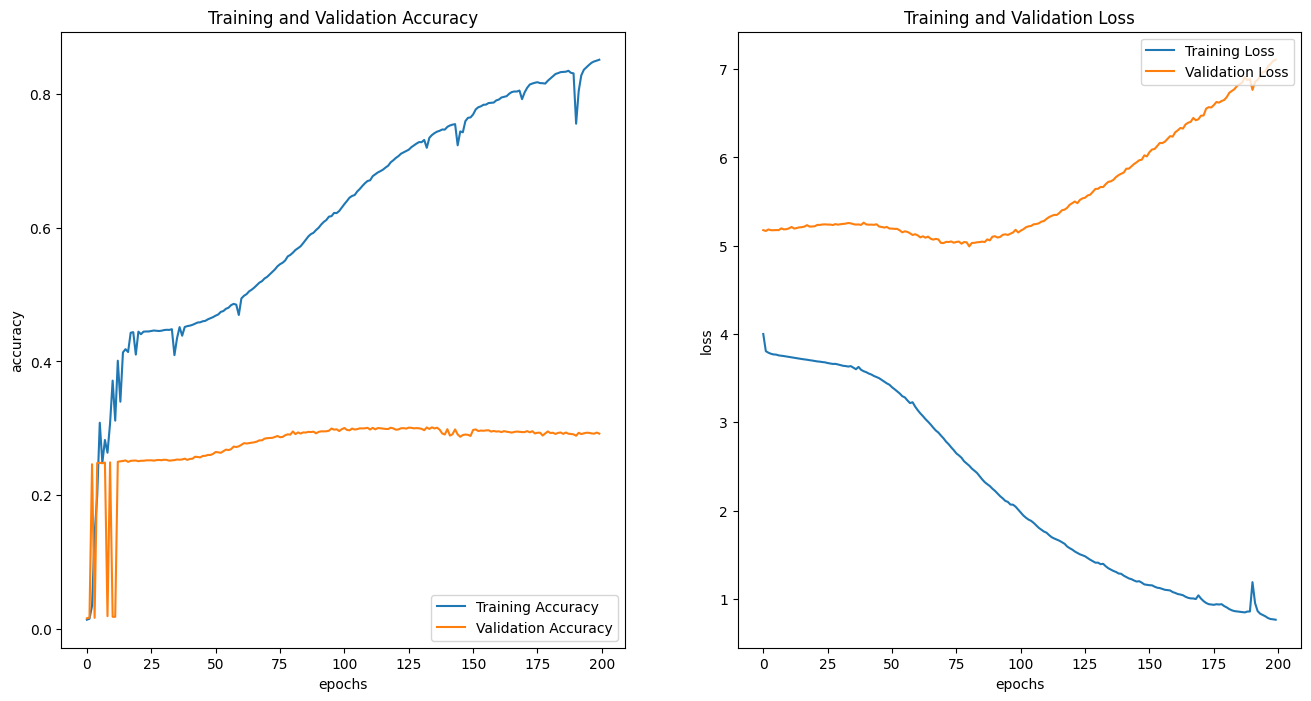

In [26]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predictions

In [33]:
from keras.models import Model
from keras.models import load_model
dimensionality = 256 # Dimensionality
# batch_size = 10   # The batch size and number of epochs
# epochs = 500

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

training_model = load_model('/content/training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
max_decoder_seq_length = 100

def decode_response(test_input):
    states_value = encoder_model.predict(test_input)
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    target_seq[0, 0, target_features_dict['<START>']] = 1.
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [hidden_state, cell_state]
    return decoded_sentence

In [34]:
class ChatBot:
  negative_responses = ("không", "xin lỗi", "cảm ơn", "sorry", "thanks", "thank you")
  exit_commands = ("tạm biệt", "thoát", "hẹn gặp lại", "goodbye", "bye")

  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs.\n")
    if user_response in self.negative_responses:
      print("Cảm ơn và hẹn gặp lại")
      return
    self.chat(user_response)

  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(clean_data(reply))+"\n")

  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    chatbot_response = chatbot_response.replace("_",' ')
    return chatbot_response

  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Cảm ơn và hẹn gặp lại")
        return True
    return False

chatbot = ChatBot()

## Demo

In [ ]:
chatbot.start_chat()